Number of lost cells (full dataset): 100,283


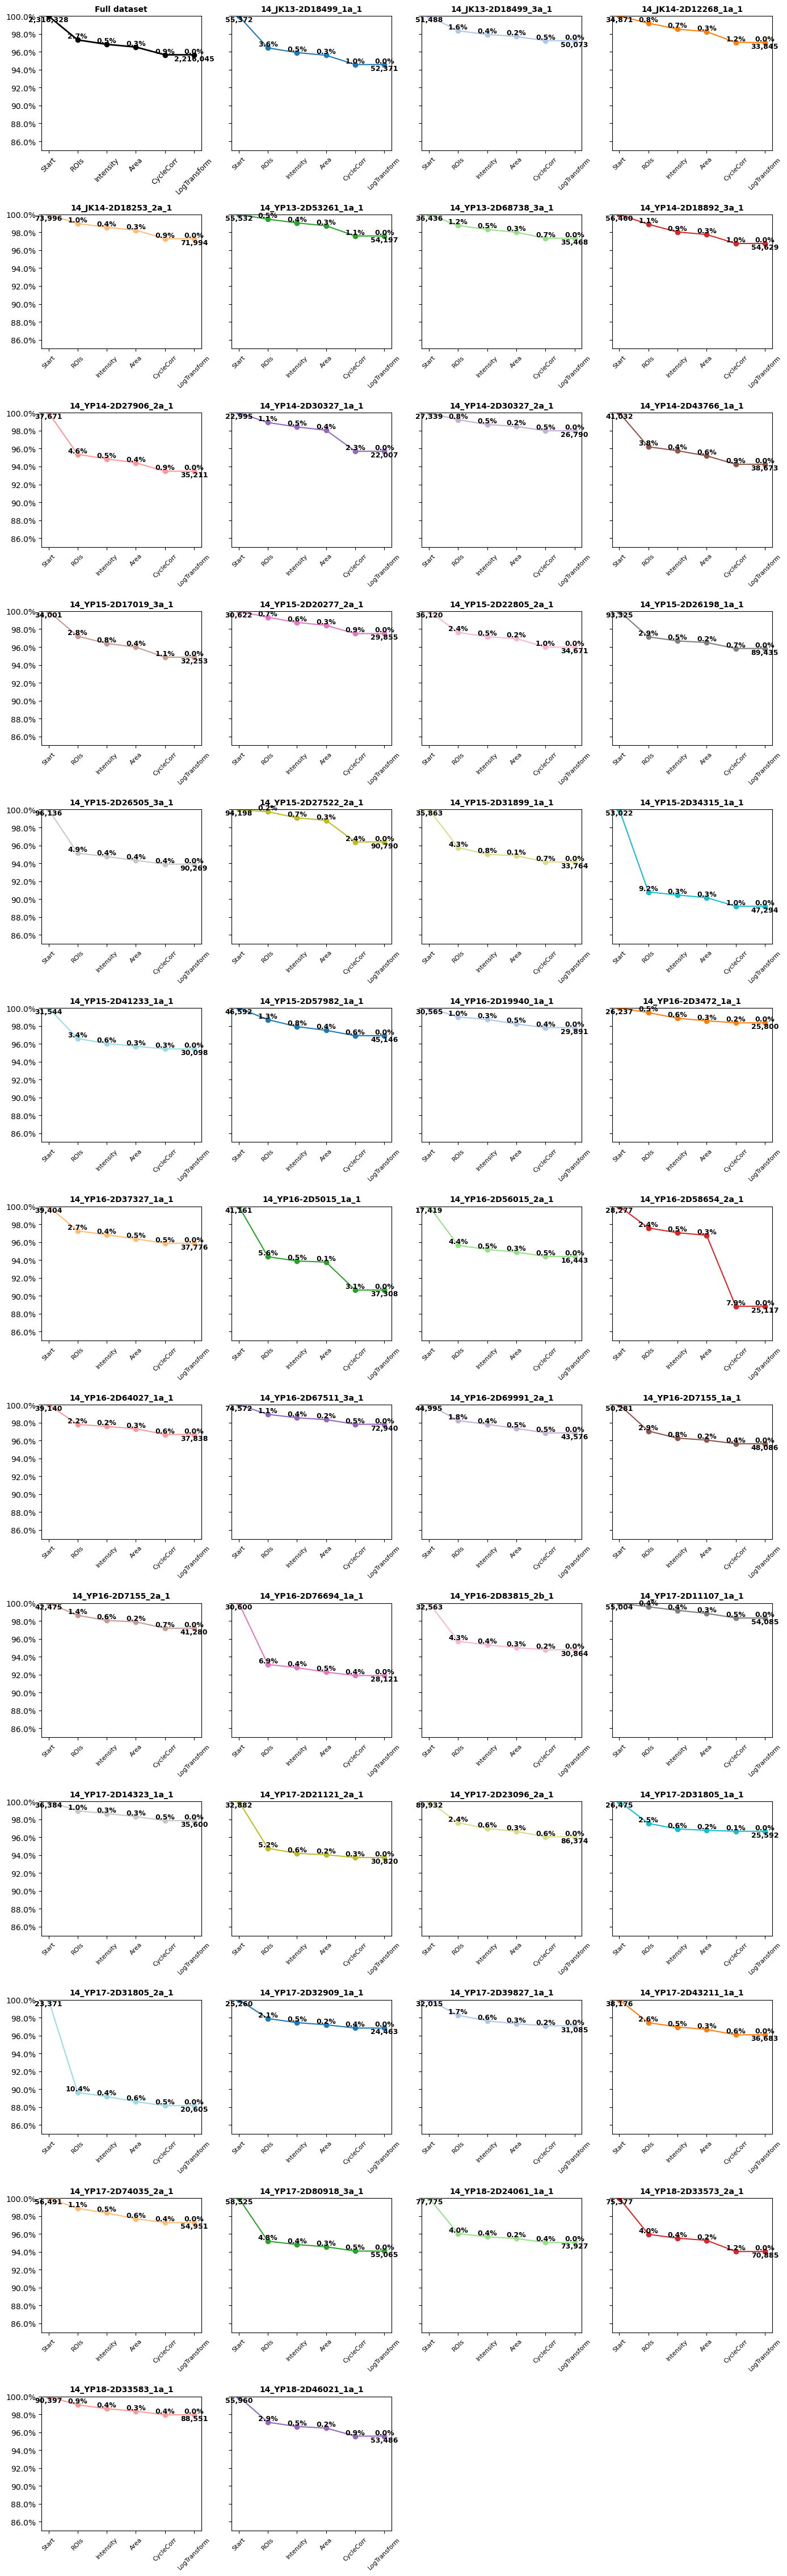

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import PercentFormatter
import math

RAW_DIR     = Path("/Volumes/CIN2_2/CIN_2_Experiment_1/csv")
CP_DIR      = Path("/Volumes/CIN2_2/CIN_2_Experiment_1/cylinter/output/checkpoints")

SAMPLE_COL  = "Sample"
MODULES     = [
    "selectROIs",
    "intensityFilter",
    "areaFilter",
    "cycleCorrelation",
    "logTransform",
]
STEP_LABELS = ["Start","ROIs","Intensity","Area","CycleCorr","LogTransform"]

def read_checkpoint(mod, sample):
    df = pd.read_parquet(CP_DIR / f"{mod}.parquet")
    return df[df[SAMPLE_COL] == sample]

SAMPLES = sorted(
    f.stem for f in RAW_DIR.glob("*.csv")
    if not f.name.startswith("._")
)

raw_data     = {}
percent_data = {}

for sample in SAMPLES:
    raw_n   = len(pd.read_csv(RAW_DIR/f"{sample}.csv"))
    counts  = [raw_n] + [ len(read_checkpoint(m, sample)) for m in MODULES ]
    raw_data[sample]     = counts
    percent_data[sample] = [c/raw_n*100 for c in counts]

full_raw     = [ sum(raw_data[s][i]     for s in SAMPLES) for i in range(len(STEP_LABELS)) ]
full_percent = [ full_raw[i] / full_raw[0] * 100 for i in range(len(STEP_LABELS)) ]

lost_full = full_raw[0] - full_raw[-1]
print(f"Number of lost cells (full dataset): {lost_full:,}")

n_panels = 1 + len(SAMPLES)
cols     = 4
rows     = math.ceil(n_panels/cols)
fig, axes = plt.subplots(rows, cols,
                         figsize=(cols*3.5, rows*3.5),
                         sharey=True)
axes = axes.flatten()
cmap = plt.get_cmap("tab20")

def annotate_subplot(ax, percents, raws, is_full=False):
    for idx, label in enumerate(STEP_LABELS):
        if idx > 0:
            # % lost from previous step
            drop = percents[idx-1] - percents[idx]
            ax.text(label, percents[idx],
                    f"{drop:.1f}%",
                    ha="center", va="bottom",
                    fontsize=9, fontweight="bold")
        if label in ("Start", "LogTransform"):
             
            ax.text(label, percents[idx],
                    f"{raws[idx]:,}",
                    ha="center", va="top",
                    fontsize=9,
                    fontweight="bold")

ax = axes[0]
ax.plot(STEP_LABELS, full_percent, marker="o", color="k", linewidth=2)
annotate_subplot(ax, full_percent, full_raw, is_full=True)
ax.set_title("Full dataset", fontsize=10, fontweight="bold")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylim(85,100)
ax.tick_params(axis="x", rotation=45, labelsize=9)

# Each sample panel
for i, sample in enumerate(SAMPLES, start=1):
    ax = axes[i]
    pct = percent_data[sample]
    raw = raw_data[sample]
    ax.plot(STEP_LABELS, pct, marker="o",
            color=cmap((i-1)%20), linewidth=1.5)
    annotate_subplot(ax, pct, raw)
    ax.set_title(sample, fontsize=10, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.set_ylim(85,100)

# Turn off any unused axes
for j in range(n_panels, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()